In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import glob
import torch
import pickle as pkl
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [3]:
tabdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables"

In [4]:
sorted(glob.glob(join(tabdir, "*.csv")))

['/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_img_DINO_embed_MHdist_all.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_invivo_all_yolo_objconf_stats.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_invivo_all_yolo_v5_stats.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_proto_mask_similarity.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_psth_dif_df.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_psth_latency_stats.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_success_rate_0.001.csv',
 '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables/Evol_success_rate_0.005.csv',
 '/n/holylabs/LABS/kempner_fellows/U

In [5]:
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=0)

In [6]:
meta_df.shape

(170, 49)

In [7]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5, device="cuda"):
    
    x = x.to(device) - mean[None, :].to(device)
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :].to(device), min=eigfloor)).sum(dim=1)


# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)

def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [46]:
import math
def gaussian_nll_with_eig(x, mean, eigvals, eigvecs, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Gaussian negative log likelihood of x given the mean, eigenvalues, and eigenvectors.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        mean (torch.Tensor): Mean tensor of shape (input_dim,).
        eigvals (torch.Tensor): Eigenvalues tensor of shape (input_dim,).
        eigvecs (torch.Tensor): Eigenvectors tensor of shape (input_dim, input_dim).

    Returns:
        torch.Tensor: Gaussian negative log likelihood tensor of shape (batch_size,).
    """
    input_dim = x.size(1)
    diff = x - mean
    eigvals_clamped = torch.clamp(eigvals.to(device), min=eigfloor)
    mahalanobis = torch.matmul(diff, eigvecs)
    mahalanobis = mahalanobis**2 / eigvals_clamped
    mahalanobis = torch.sum(mahalanobis, dim=1)
    log_det = torch.sum(torch.log(eigvals_clamped))
    nll = 0.5 * (input_dim * math.log(2 * math.pi) + log_det + mahalanobis)
    return nll


In [8]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")
Evol_embed_dir = '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

In [9]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [10]:
meta_df.loc[3]

Animal                         Beto
expdate                  2020-07-22
ephysFN           Beto-22072020-002
prefchan                          5
prefunit                          2
visual_area                      IT
space1                          fc6
space2                 BigGAN_class
optim_names1                  CMAES
optim_names2                  CMAES
blockN                           47
t_endinit_0               12.070376
p_endinit_0                     0.0
t_endinit_1               11.156463
p_endinit_1                     0.0
t_maxinit_0               12.653157
p_maxinit_0                     0.0
t_maxinit_1               11.903322
p_maxinit_1                     0.0
t_maxend_0                -0.679212
p_maxend_0                 0.497998
t_maxend_1                 0.895529
p_maxend_1                 0.372699
t_FCBG_end_01             -4.440703
p_FCBG_end_01              0.000019
t_FCBG_max_01             -6.618689
p_FCBG_max_01                   0.0
maxrsp_0_mean            223

In [11]:
meta_df.loc[190][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()

{'Animal': 'Alfa',
 'expdate': '2020-09-28',
 'ephysFN': 'Alfa-28092020-008',
 'prefchan': 45,
 'prefunit': 1,
 'visual_area': 'V1',
 'space1': 'fc6',
 'space2': 'BigGAN_class',
 'optim_names1': 'CMAES',
 'optim_names2': 'CMAES',
 'blockN': 19}

In [47]:
# compute mahalanobis distance for all Exps
from tqdm import tqdm, trange
stats_df_col = []
for Expi in tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    if Expi not in meta_df.index:
        continue
    meta_dict = meta_df.loc[Expi][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    for thread in [0, 1]:
        stats_col = {}
        embeddings = Evol_data[f"embeddings{thread}"]
        gen_vec = Evol_data[f"gen_vec{thread}"]
        resp_mat = Evol_data[f"resp_mat{thread}"]
        stats_col["Expi"] = Expi
        stats_col["thread"] = thread
        stats_col["generation"] = gen_vec
        stats_col["resp_mean"] = resp_mat[:, 0]
        for dataset_str in MH_eig_col:
            data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
            MHdist_thread = mahalanobis_sqdist(embeddings.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
            NLL_thread = gaussian_nll_with_eig(embeddings.cuda(), data_mean, data_eigvals, data_eigvecs, eigfloor=1e-3).cpu()
            stats_col[f"MHdist_{dataset_str}"] = MHdist_thread
            stats_col[f"NLL_{dataset_str}"] = NLL_thread
        stats_col.update(meta_dict)
        stats_df = pd.DataFrame(stats_col)
        stats_df_col.append(stats_df)
    # raise RuntimeError("Stop here")
stats_df_all = pd.concat(stats_df_col, ignore_index=True)

 29%|██▉       | 56/190 [00:00<00:01, 89.65it/s]

100%|██████████| 190/190 [00:02<00:00, 89.55it/s]


In [49]:
NLL_thread.shape

torch.Size([480])

In [48]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_all.csv"))

In [14]:
stats_df_all.columns

Index(['Expi', 'thread', 'generation', 'resp_mean', 'MHdist_DeePSim_4std',
       'MHdist_BigGAN_trunc07', 'MHdist_BigGAN_std_008',
       'MHdist_imagenet_valid', 'Animal', 'expdate', 'ephysFN', 'prefchan',
       'prefunit', 'visual_area', 'space1', 'space2', 'optim_names1',
       'optim_names2', 'blockN'],
      dtype='object')

In [18]:
from neuro_data_analysis.neural_data_utils import get_all_masks
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [26]:
list(meta_df)

['Animal',
 'expdate',
 'ephysFN',
 'prefchan',
 'prefunit',
 'visual_area',
 'space1',
 'space2',
 'optim_names1',
 'optim_names2',
 'blockN',
 't_endinit_0',
 'p_endinit_0',
 't_endinit_1',
 'p_endinit_1',
 't_maxinit_0',
 'p_maxinit_0',
 't_maxinit_1',
 'p_maxinit_1',
 't_maxend_0',
 'p_maxend_0',
 't_maxend_1',
 'p_maxend_1',
 't_FCBG_end_01',
 'p_FCBG_end_01',
 't_FCBG_max_01',
 'p_FCBG_max_01',
 'maxrsp_0_mean',
 'maxrsp_0_std',
 'maxrsp_0_sem',
 'maxrsp_1_mean',
 'maxrsp_1_std',
 'maxrsp_1_sem',
 'endrsp_0_mean',
 'endrsp_0_std',
 'endrsp_0_sem',
 'endrsp_1_mean',
 'endrsp_1_std',
 'endrsp_1_sem',
 'initrsp_0_mean',
 'initrsp_0_std',
 'initrsp_0_sem',
 'initrsp_1_mean',
 'initrsp_1_std',
 'initrsp_1_sem',
 'space_names1',
 'space_names2',
 'optim_names1_y',
 'optim_names2_y']

In [19]:
mask_dict = get_all_masks(meta_df, return_type=dict)

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [27]:
FCsucs_msk = meta_df.p_maxinit_0 < 0.05 
BGsucs_msk = meta_df.p_maxinit_1 < 0.05
bothsucs_msk = FCsucs_msk & BGsucs_msk
anysucs_msk = FCsucs_msk | BGsucs_msk

In [20]:
Expi_masks = meta_df[validmsk].index

In [28]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

In [50]:
stats_df_all.groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             907.389709         1228.193726         1152.252441   
            1            4115.888672         1326.638184         1264.182373   
V1          0             840.587769         1224.839966         1149.420288   
            1            3013.536133         1277.641968         1203.742798   
V4          0             843.243164         1226.365112         1153.213867   
            1            3234.308838         1289.146118         1217.587646   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1393.744385  
            1              1389.596436  
V1          0              1394.820435  
            1              1375.331543  
V4          0              1394.499512  
            1              1379.713745

In [51]:
stats_df_all[stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)].\
            groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             852.661194         1229.201782         1152.918457   
            1            4184.769531         1326.885498         1272.502075   
V1          0             835.433044         1229.087036         1151.809082   
            1            3083.922363         1289.077881         1278.582886   
V4          0             851.630066         1225.626953         1152.172852   
            1            3416.262207         1298.872192         1251.041870   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1395.097534  
            1              1390.723511  
V1          0              1397.387207  
            1              1385.892334  
V4          0              1393.409058  
            1              1387.322754

In [34]:
stats_df_all.groupby(["visual_area", "thread"])[["MHdist_DeePSim_4std", 
                                                "MHdist_BigGAN_trunc07", 
                                                "MHdist_BigGAN_std_008", 
                                                "MHdist_imagenet_valid"]].mean()

MHdist_DeePSim_4std  MHdist_BigGAN_trunc07  \
visual_area thread                                               
IT          0               1247.661743             614.068970   
            1               7664.659668             810.957886   
V1          0               1114.057861             607.361633   
            1               5459.954590             712.965515   
V4          0               1119.368774             610.411926   
            1               5901.500000             735.973816   

                    MHdist_BigGAN_std_008  MHdist_imagenet_valid  
visual_area thread                                                
IT          0                  739.571228             769.460327  
            1                  963.431091             761.164429  
V1          0                  733.907043             771.612549  
            1                  842.552063             732.634766  
V4          0                  741.494080             770.970703  
            1                  870.241882             741.399048

Text(0.5, 0, 'Generation')

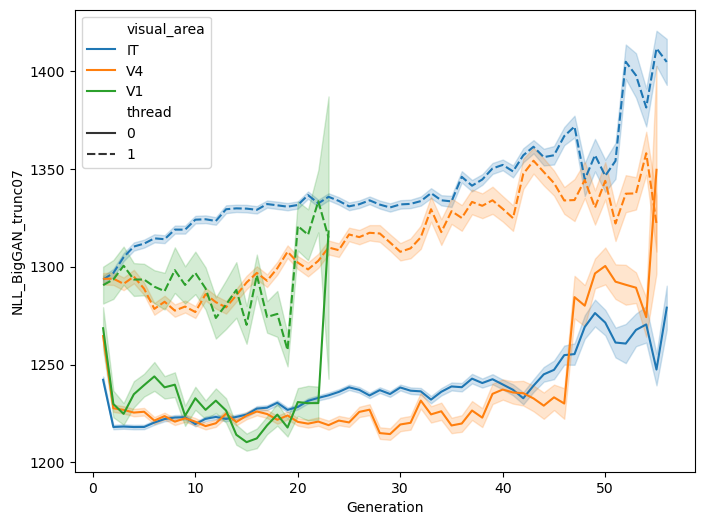

In [54]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="NLL_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

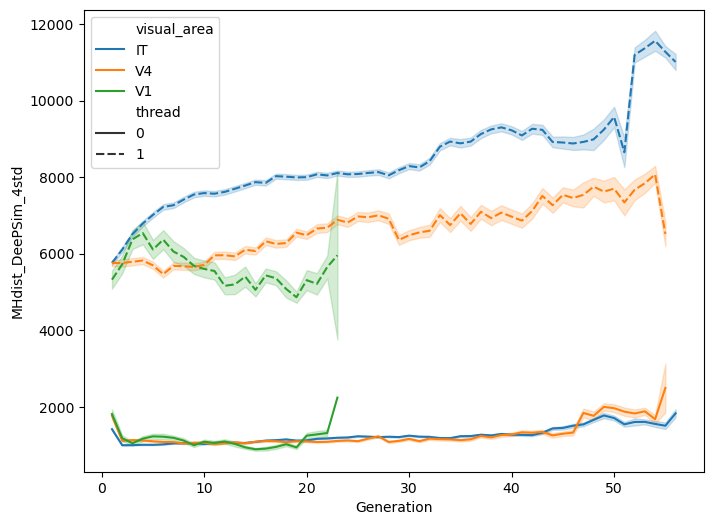

In [32]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

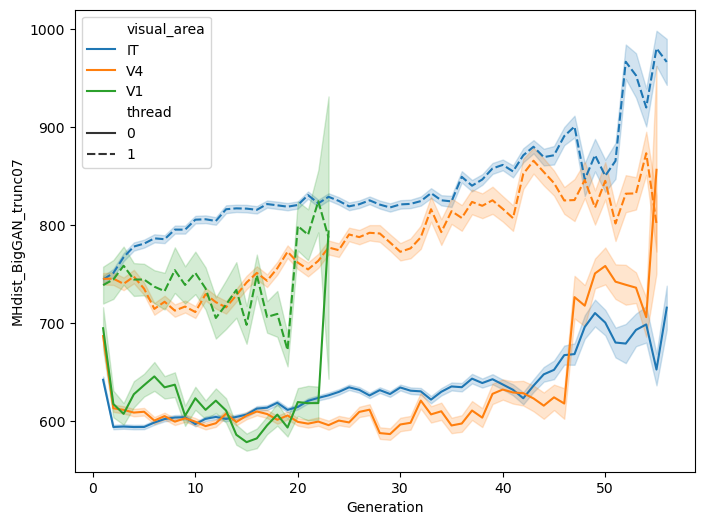

In [30]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

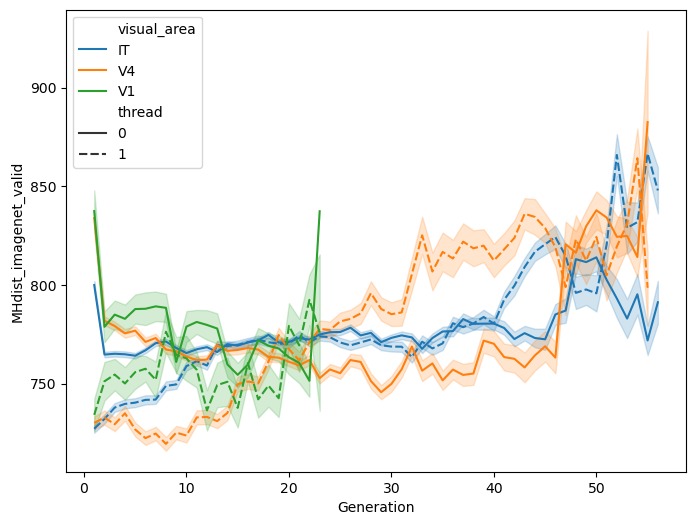

In [29]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

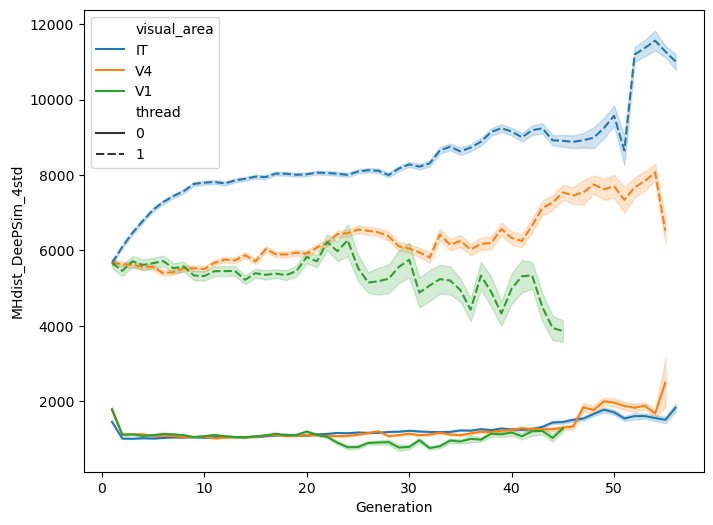

In [23]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

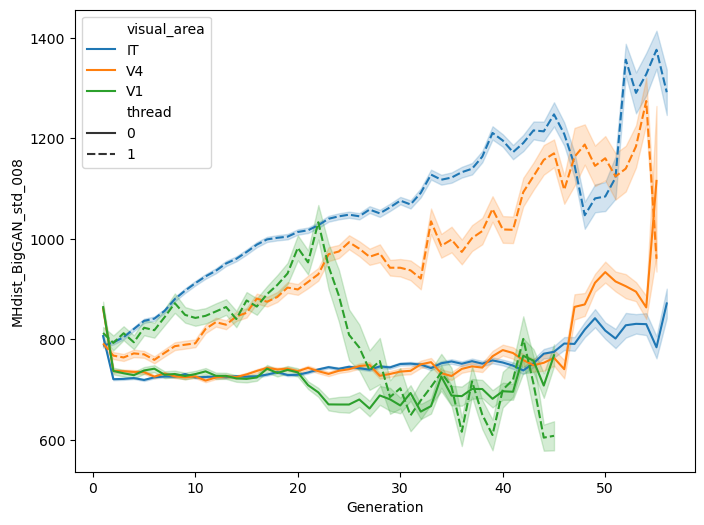

In [25]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_std_008", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

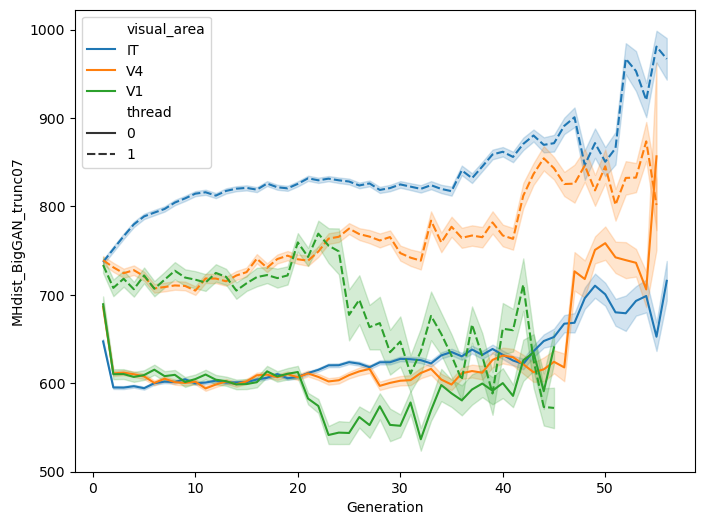

In [24]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

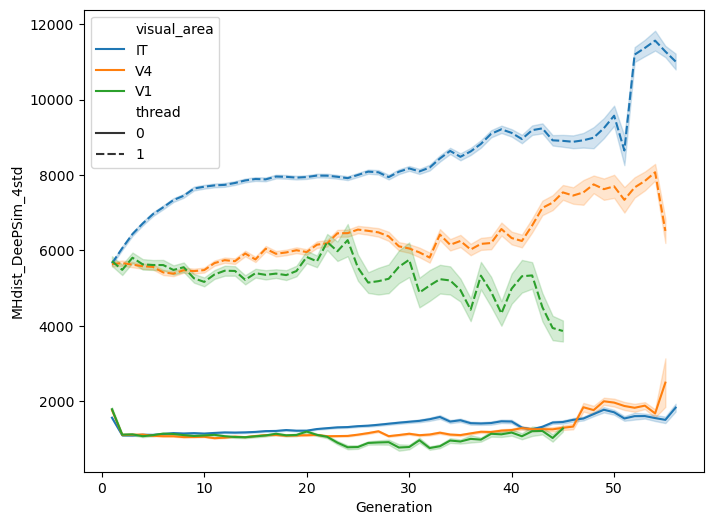

In [22]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all, x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

In [40]:
stats_df_all.head()

,Expi,thread,generation,resp_mean,MHdist_DeePSim_4std,MHdist_BigGAN_trunc07,MHdist_BigGAN_std_008,MHdist_imagenet_valid,Animal,expdate,ephysFN,prefchan,prefunit,visual_area,space1,space2,optim_names1,optim_names2,blockN
0,3,0,1,159.850917,2023.482788,709.821045,773.775513,764.919556,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
1,3,0,1,105.139166,475.572205,578.988525,750.697266,860.580566,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
2,3,0,1,114.781936,661.421814,428.486450,530.101318,648.805298,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
3,3,0,1,113.217269,649.972534,447.669067,551.429688,670.945801,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47
4,3,0,1,204.278660,1743.674438,708.540222,827.158691,752.601074,Beto,2020-07-22,Beto-22072020-002,5,2,IT,fc6,BigGAN_class,CMAES,CMAES,47


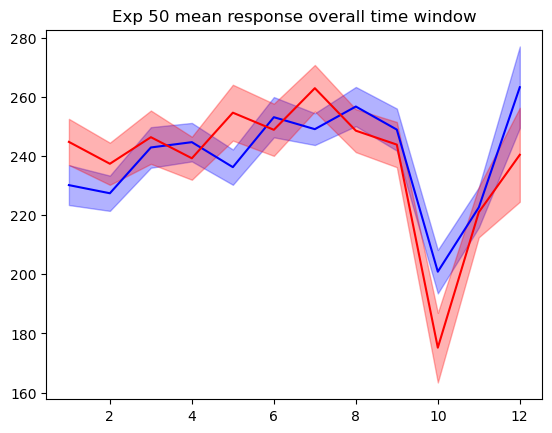

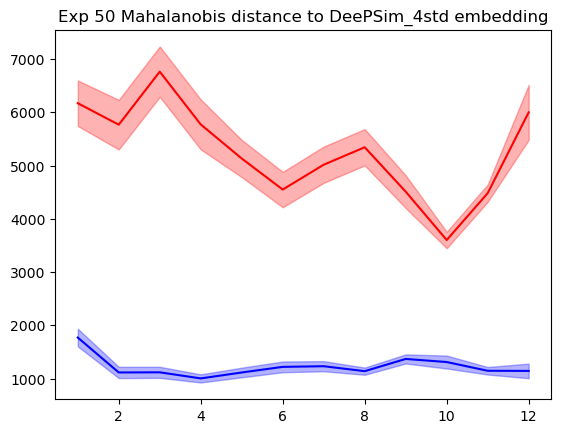

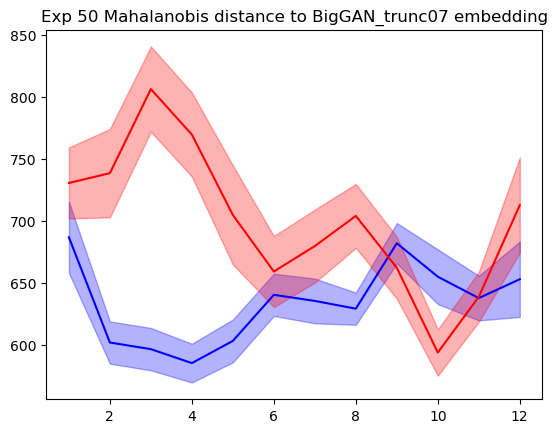

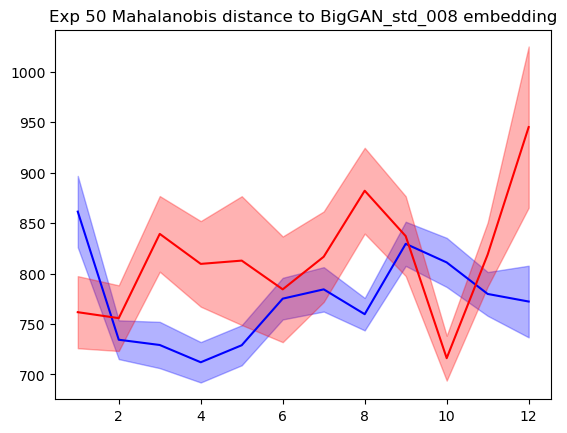

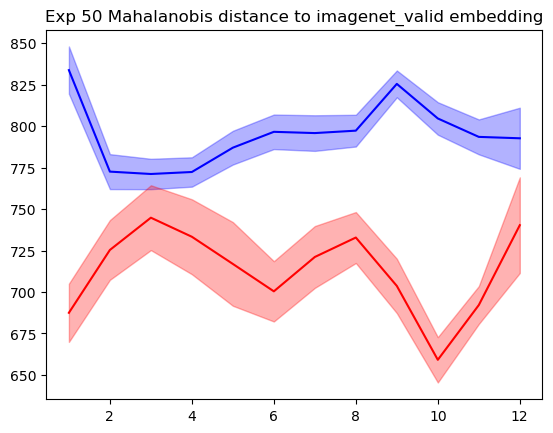

In [10]:
# Expi = 184
for Expi in [50]:#tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    embeddings0 = Evol_data["embeddings0"]
    embeddings1 = Evol_data["embeddings1"]
    imgfps0 = Evol_data["imgfps0"]
    imgfps1 = Evol_data["imgfps1"]
    resp_mat0 = Evol_data["resp_mat0"]
    resp_mat1 = Evol_data["resp_mat1"]
    gen_vec0 = Evol_data["gen_vec0"]
    gen_vec1 = Evol_data["gen_vec1"]
    # MHdist_0 = mahalanobis_sqdist(embeddings0, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
    # MHdist_1 = mahalanobis_sqdist(embeddings1, IN_mean, IN_eigvec, IN_eigval, eigfloor=1e-2)
    plt.figure()
    plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
    plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
    plt.title(f"Exp {Expi} mean response overall time window")
    plt.show()
    for dataset_str in MH_eig_col:
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        MHdist_0 = mahalanobis_sqdist(embeddings0.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        MHdist_1 = mahalanobis_sqdist(embeddings1.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        # Evol_data[f"MHdist_{dataset_str}_0"] = MHdist_0
        # Evol_data[f"MHdist_{dataset_str}_1"] = MHdist_1
        plt.figure()
        plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
        plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
        plt.title(f"Exp {Expi} Mahalanobis distance to {dataset_str} embedding")
        plt.show()